In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import os, os.path
import numpy as np
import scipy
from glob import glob
import cartopy.crs as ccrs

%matplotlib inline

In [2]:
sst_filename = '/Users/leo/workspace/data/ERSST/v3b/netcdf/sst_all.nc'
ds_sst = xr.open_dataset(sst_filename)
ds_sst = ds_sst.squeeze('lev') # remove singleton dimension
ds_sst_tropical = ds_sst.sel(lat=slice(-20.,20), time=slice('1978','2012'))

if (1):
    # ERA INTERIM 200 HPA GEOPOTENTIAL HEIGHT
    REANALYSIS = "ERA-I"
    h250_filename = '/Users/leo/workspace/data/ERA-Interim/geopotential_flt_1979-2012.nc'
    ds_h250_global = xr.open_dataset(h250_filename)

    ds_h250 = ds_h250_global.sel(latitude=slice(88.5,0))
    ds_h250['lat']=ds_h250['latitude']
    ds_h250['lon']=ds_h250['longitude']
    

else:
    # MERRA2 250 hPa geopotential height
    REANALYSIS = "MERRA2"
    h250_filename = '/Users/leo/workspace/data/MERRA2/H250/H250_all.nc'
    ds_h250 = xr.open_dataset(h250_filename)
    ds_h250['Z200'] = ds_h250['H250'] # workaround for mismatching variable names TODO: handle properly

In [3]:
myproj = ccrs.PlateCarree()

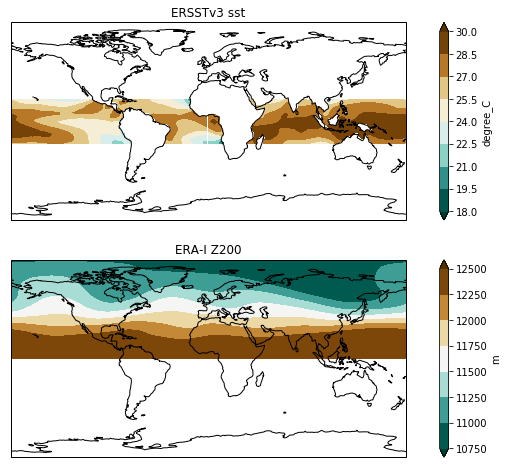

In [4]:
fig, axes = plt.subplots(2, figsize=(12,8),subplot_kw={'projection': ccrs.PlateCarree()})
#cmap='viridis'
cmap='BrBG_r'

for ax, ds, varname, dataset in zip(axes, [ds_sst_tropical,ds_h250], ['sst','Z200'], ["ERSSTv3",REANALYSIS]):
    lon2d, lat2d = np.meshgrid(ds.variables['lon'], ds.variables['lat'])

    cf = ax.contourf(lon2d, lat2d, ds.variables[varname][0,:,:], 
        transform=myproj, 
        cmap=cmap, extend='both')
    ax.set_title(dataset + " " + varname)
    ax.coastlines()
    ax.set_global()
    cb = fig.colorbar(cf, ax=ax, label=ds[varname].units)


# Take anomalies and collapse spatial dimensions

In [5]:
sst_ANN = ds_sst_tropical['sst'].groupby(ds_sst_tropical['time.year']).mean(dim='time')
sst_ANN_diff = sst_ANN - sst_ANN.mean(axis=0) # anomalies

(nt, nx, ny) = sst_ANN.shape
sst_ANN_flat = sst_ANN_diff.values.reshape(nt,nx*ny)
#sst_ANN_flat.shape

# no SST over land, these result in NaNs we need to filter out
mynan = np.isnan(sst_ANN_flat[0,:])
#mynan.shape

sst_ANN_flat_nonan = sst_ANN_flat[:,~mynan]

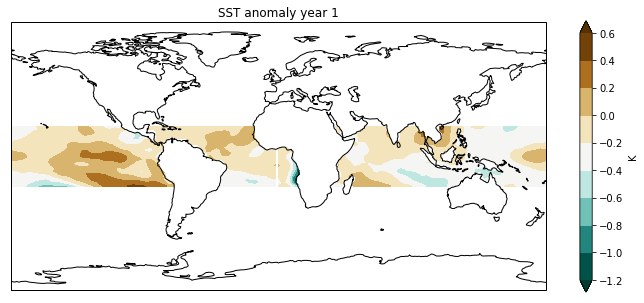

In [6]:
lon2d, lat2d = np.meshgrid(ds_sst_tropical.variables['lon'], ds_sst_tropical.variables['lat'])
fig, ax = plt.subplots(1, figsize=(12,5),subplot_kw={'projection': myproj})

cf = ax.contourf(lon2d, lat2d, sst_ANN_diff[0,:,:],
        transform = myproj, 
        cmap=cmap, extend='both')
cb = fig.colorbar(cf,ax=ax,label='K')

ax.coastlines()
ax.set_title('SST anomaly year 1')
ax.set_global()

In [7]:
years = sst_ANN['year']

In [8]:
h250_ANN = ds_h250['Z200'].groupby(ds_h250['time.year']).mean(dim='time')
h250_ANN_diff = h250_ANN - h250_ANN.mean(axis=0) # anomalies

h250_ANN_diff = h250_ANN_diff[:,::4,::4] # resampling to 2 deg TODO remove
(nt2, nx2, ny2) = h250_ANN_diff.shape
h250_ANN_flat = h250_ANN_diff.values.reshape(nt2,nx2*ny2)

# 0.5 degree resolution gives long array 
h250_ANN_flat.shape

(34, 3600)

(34, 30, 120)
(21, 180)


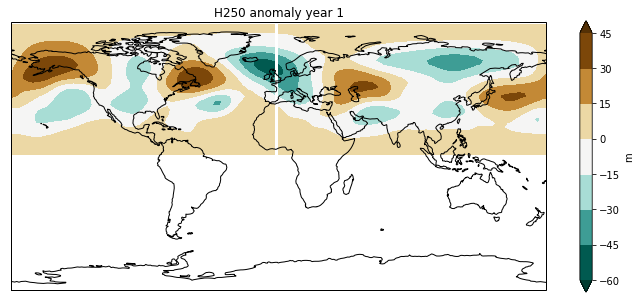

In [9]:
print(h250_ANN_diff.shape)
print(lon2d.shape)

lon2d, lat2d = np.meshgrid(ds_h250.variables['lon'][::4], ds_h250.variables['lat'][::4])
fig, ax = plt.subplots(1, figsize=(12,5),subplot_kw={'projection': myproj})

cf = ax.contourf(lon2d, lat2d, h250_ANN_diff[0,:,:],
        transform = myproj, 
        cmap=cmap, extend='both')
fig.colorbar(cf,ax=ax,label='m')
ax.coastlines()
ax.set_title('H250 anomaly year 1')
ax.set_global()

In [10]:
nt == nt2

True

# Covariance matrix

In [11]:
def cosdeg(ar):
    """ Cosine in degrees"""
    return np.cos(np.deg2rad(ar))

def sindeg(ar):
    """ sine in degrees"""
    return np.sin(np.deg2rad(ar))


LAT_SCALING = 1

if (LAT_SCALING):
    """
    Note: weighting observations

    Generally, when performing and EOF analysis on observations over the globe or a portion of the globe, 
    the values are weighted prior to calculating. This is usually required to account for the convergence 
    of the meridions (area weighting) which lessens the impact of high-latitude grid points that represent 
    a small area of the globe. Most frequently, the square root of the cosine of the latitude is used to 
    compute the area weight. The square root is used to create a covariance matrix that reflects the area 
    of each matrix element. If weighted in this manner, the resulting covariance values will include 
    quantities calculated via:

    [x*sqrt(cos(lat(x)))]*[y*sqrt(cos(lat(y)))] = x*y*sqrt(cos(lat(x)))*sqrt(cos(lat(y)))

    Note that the covariance of a grid point with itself yields standard cosine weighting:
    
    [x*sqrt(cos(lat(x)))]*[x*sqrt(cos(lat(x)))] = x^2 * cos(lat(x)).

    source: http://www.ncl.ucar.edu/Document/Functions/Built-in/eofcov.shtml
    """
       
    #spatial weights for dataset 1: SST
    lon2d, lat2d = np.meshgrid(ds_sst_tropical.variables['lon'], ds_sst_tropical.variables['lat'])
    lat2d_flat = lat2d.reshape(nx*ny)
    lat2d_flat_nt = np.tile(lat2d_flat,1).reshape(1,nx*ny)
    lat2d_flat_nt_nonan = lat2d_flat_nt[:,~mynan]
    w1 = np.sqrt(cosdeg(lat2d_flat_nt_nonan))
    print('w1 shape',w1.shape,'min=',w1.min())
    
    #spatial weights for dataset 2: H250
    lon2d, lat2d = np.meshgrid(ds_h250.variables['lon'], ds_h250.variables['lat'])
    lat2d = lat2d[::4,::4] # resampling to 2 deg TODO remove
    lat2d_flat = lat2d.reshape(nx2*ny2)
    lat2d_flat_nt = np.tile(lat2d_flat,1).reshape(1,nx2*ny2)
    w2 = np.sqrt(cosdeg(lat2d_flat_nt))
    print('w2 shape',w2.shape, 'min=', w2.min())

    weight = np.dot(w1.T, w2)
    
    # Default (weighting for both fields)
    #Cxy_w = np.dot( (sst_ANN_flat_nonan * w1).T, h250_ANN_flat * w2)/(nt-1.)
    
    # No weighting for SST
    Cxy_w = np.dot( (sst_ANN_flat_nonan).T, h250_ANN_flat * w2)/(nt-1.)
    
    # No weighting for SST and change order of matrix multiplication
    #Cxy_w = np.dot( (h250_ANN_flat * w2).T, (sst_ANN_flat_nonan) )/(nt-1.)
    
else:
    Cxy = np.dot(sst_ANN_flat_nonan.T, h250_ANN_flat)/(nt-1.)

w1 shape (1, 2951) min= 0.969377439796
w2 shape (1, 3600) min= 0.161792917978


# SVD

In [12]:
if (LAT_SCALING):
    print("Covariance matrix is scaled by sqrt(cos(latitude))")
    U, s, Vh = scipy.linalg.svd(Cxy_w, full_matrices=False)
else:
    print("Covariance matrix is not scaled for latitude")
    U, s, Vh = scipy.linalg.svd(Cxy, full_matrices=False)

Covariance matrix is scaled by sqrt(cos(latitude))


[ 0.53549731  0.40223815  0.0288162 ]


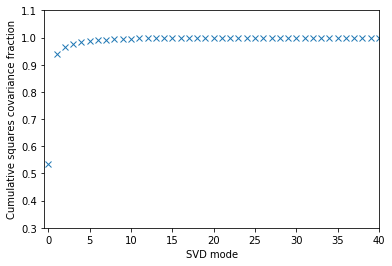

In [13]:
scf = s**2./np.sum(s**2.)
print(scf[:3])
plt.plot(np.cumsum(scf),'x') # cumulative fraction of squares covariance explained
plt.xlabel('SVD mode')
plt.ylabel('Cumulative squares covariance fraction')
plt.ylim([.3,1.1])
plt.xlim([-.5, 40])
plt.show()

In [14]:
U.shape, Vh.shape, s.shape

((2951, 2951), (2951, 3600), (2951,))

# Extract modes

In [15]:
# imode = mode number to extract
imode = 0
scf[imode]

0.53549731223620389

In [16]:
# original data
if (LAT_SCALING):
    X = (w1 * sst_ANN_flat_nonan).T # L x Nt
    Y = (w2 * h250_ANN_flat).T # M x Nt 
else:
    X = sst_ANN_flat_nonan.T # L x Nt
    Y = h250_ANN_flat.T # M x Nt 
    
X.shape, Y.shape

((2951, 34), (3600, 34))

In [17]:
# Expansion coefficients (right)
Vstar_k = np.dot(Vh[imode,:], Y)

In [18]:
# Expansion coefficients (left)
Ustar_k = np.dot(U[:,imode].T, X)

In [19]:
# Check that the V*_k vector is really a column of V*
Vstar = np.dot(Vh, Y)
np.allclose(Vstar[imode,:],Vstar_k)

True

In [20]:
# The singular value is also equal to the covariance between the expansion 
# coefficients X* and Y* of the two fields
np.dot(Ustar_k, Vstar_k), s[0], s[0]*(nt-1), 'we need to scale by nt'

(159463.79423350838,
 4891.0559303946211,
 161404.8457030225,
 'we need to scale by nt')

In [21]:
# Normalize expansion coefficients (std = 1)
Vstar_kn = Vstar_k / Vstar_k.std()
Ustar_kn = Ustar_k / Ustar_k.std()
Vstar_kn.std(), Ustar_kn.std()

(1.0000000000000002, 1.0)

In [22]:
# project data onto expansion coefficients 
# MCA analysis is a little different than EOF analysis, since to get the structure of the left field, 
# you project the left field data onto the expansion coefficient of the right singular vector, and vice versa.
u_k = 1/((nt-1) * s[imode]) * np.dot(X, Vstar_k.T)
v_k = 1/((nt-1) * s[imode]) * np.dot(Y, Ustar_k.T)

# project data onto expansion coefficients (amplitude preserving)
# The amplitude information associated with the singular vector expansion can be incorporated into 
# the singular vector patterns for display purposes by mapping the covariance between the normalized 
# expansion coefficient time series (set standard deviation to one) of the left singular vector with 
# the right data field and vice versa
u_ka = np.dot(X, Vstar_kn.T) 
v_ka = np.dot(Y, Ustar_kn.T)

# Display SST mode

In [23]:
#modeSST = u_k
#modeSST = u_ka
modeSST = -u_ka / (nt-1) # sign is arbitrary
modeSST.shape

(2951,)

In [24]:
# Display modal information
mc_sst = np.ma.masked_array(np.zeros(sst_ANN_flat.shape[1])) # no time dimension
mc_sst[~mynan] = modeSST
mc_sst[mynan] = np.ma.masked
mc_sst = mc_sst.reshape(nx,ny) #* stt_ANN[0,:,:] # multiply with anomalies
print(mc_sst.shape)

# convert to DataArray to facilitate further processing
mc_sst_da = xr.DataArray(mc_sst, coords=[ds_sst_tropical['lat'], ds_sst_tropical['lon']], dims=['lat', 'lon'])

#ds_sst_tropical['lat']
#mc1_sst_da
#mc_sst_da.values

(21, 180)


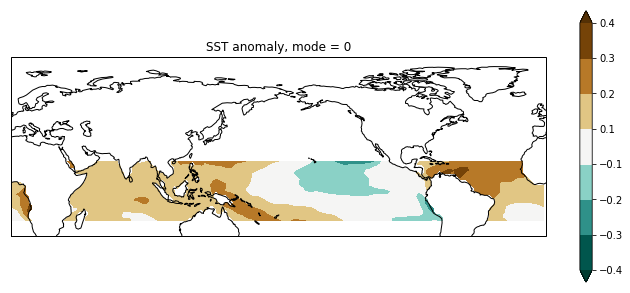

In [25]:
myproj2 = ccrs.PlateCarree(central_longitude = -180.)
fig, axes = plt.subplots(1, figsize=(12,5),subplot_kw={'projection': myproj2})
cmap='BrBG_r'

def plot_mode_sst(ds, ax):    
    lon2d, lat2d = np.meshgrid(ds['lon'], ds['lat'])
    absmax = np.abs(ds).max().values
    levs = [-1,-0.7,-0.4,-0.1,0.1,0.4,0.7,1]
    levs = [-0.4,-0.3,-0.2,-0.1,0.1,0.2,0.3,0.4]
#    levs = np.linspace(-absmax, absmax, 11)
    
    cf = ax.contourf(lon2d, lat2d, ds.values, 
        transform = myproj, levels=levs,
        cmap=cmap, extend='both')
    
    ax.coastlines()
    ax.set_global()
    ax.set_ylim(-30,90)

    ax.set_title('SST anomaly, mode = %d' % imode)
    cb = fig.colorbar(cf, ax=ax)
    #ax.set_extent([1, 360, -30, 90], myproj)

ax = axes
plot_mode_sst(mc_sst_da, ax)


(-3, 3)

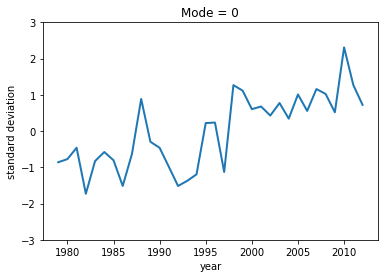

In [26]:
# left time series
a1 = np.dot(modeSST, X).squeeze()
plt.plot(years,a1/np.std(a1),lw=2)

#a1 = np.dot(U[:,imode, np.newaxis].T, sst_ANN_flat_nonan.T).squeeze()
#plt.plot(years,a1/np.std(a1),lw=2)

# standardized amplitude
plt.xlabel('year')
plt.ylabel('standard deviation')
plt.title('Mode = %d' % imode)
plt.ylim((-3,3))

# Display H250 mode

In [27]:
#V = Vh.T # linalg.svd returns V transpose. We want V. 

# Give the eigenvectors the right amplitude
#Vs = 1/np.sqrt(nx2*ny2) * np.dot(np.diag(s), Vh)
#V = Vs.T

#if (LAT_SCALING):
#    modeH250 = -V[:,imode] 
#else:
#    modeH250 = -V[:,imode] 


#modeH250 = v_k
#modeH250 = v_ka
modeH250 = -v_ka / (nt-1) # sign is arbitrary
modeH250.shape

(3600,)

In [28]:
mc_h250 = np.ma.masked_array(np.zeros(h250_ANN_flat.shape[1])) # no time dimension

mc_h250[:] = modeH250
mc_h250 = mc_h250.reshape(nx2,ny2) #* stt_ANN[0,:,:] # multiply with anomalies
#mc1_h250.shape
mc_h250_da = xr.DataArray(mc_h250, coords=[ds_h250['lat'][::4], ds_h250['lon'][::4]], dims=['lat', 'lon'])
#mc1_h250_da

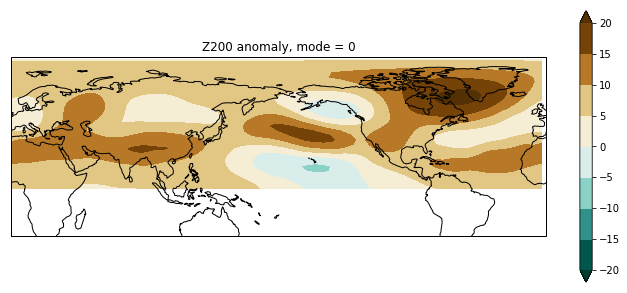

In [29]:
myproj2 = ccrs.PlateCarree(central_longitude = -180.)
fig, axes = plt.subplots(1, figsize=(12,5),subplot_kw={'projection': myproj2})
#cmap='viridis'
cmap='BrBG_r'

#for ax, ds, varname in zip(axes, [ds_sst_tropical,ds_h250], ['sst','H250']):

def plot_mode_z200(ds, ax):
    absmax = np.abs(ds.values).max()
    #levs = np.linspace(-absmax, absmax, 11)
    levs = np.asarray([-20, -15, -10, -5, 0, 5, 10, 15, 20])
    lon2d, lat2d = np.meshgrid(ds['lon'], ds['lat'])

    cf = ax.contourf(lon2d, lat2d, ds.values, 
        transform = myproj, levels=levs,
        cmap=cmap, extend='both')

    ax.coastlines()
    #ax.set_global()
    ax.set_title('Z200 anomaly, mode = %d' % imode)

    cb = fig.colorbar(cf, ax=ax)
    #ax.set_extent([1, 360, -30, 90], myproj)
    ax.set_ylim(-30,90)
        
ax = axes
plot_mode_z200(mc_h250_da, ax)

(34,)


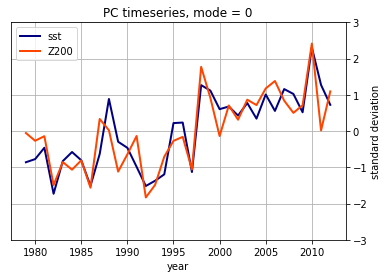

In [30]:

def plot_mode_pc(ax):
    """
    Made a function for re-usability
    """
    # right time series
    b1 = np.dot(modeH250, Y).squeeze()
    #b1 = np.dot(-V[:,imode, np.newaxis].T, h250_ANN_flat.T).squeeze()
    print(b1.shape)

    # standardized amplitude
    ax.plot(years, a1[:] / np.std(a1),lw=2, label='sst', color='navy')
    ax.plot(years, b1[:] / np.std(b1),lw=2, label='Z200', color='orangered')

    ax.set_xlabel('year')
    ax.set_ylabel('standard deviation')
    ax.set_ylim((-3,3))
    ax.grid()
    ax.legend()
    ax.set_title('PC timeseries, mode = %d' % imode)
    ax.yaxis.tick_right()
    ax.yaxis.set_label_position("right")
    
fig, ax = plt.subplots(1)
plot_mode_pc(ax)

# All plots combined

(34,)


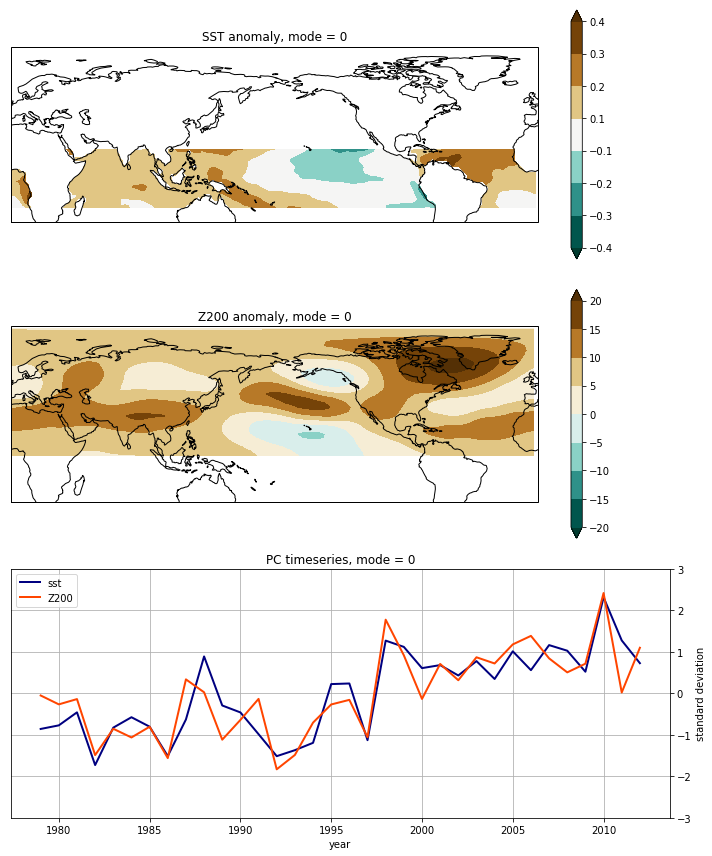

In [31]:

myproj2 = ccrs.PlateCarree(central_longitude = -180.)
#fig, axes = plt.subplots(nrows=3, figsize=(10,12),subplot_kw={'projection': myproj2})

fig = plt.figure(figsize=(10,12))

ax0 = fig.add_subplot(311, projection = myproj2)
ax1 = fig.add_subplot(312, projection = myproj2)
ax2 = fig.add_subplot(313)

#fig, axes = plt.subplots(nrows=3, figsize=(10,12))
#cmap='viridis'
cmap='BrBG_r'

#for ax, ds, varname in zip(axes, [ds_sst_tropical,ds_h250], ['sst','H250']):
#ax = axes

plot_mode_sst(mc_sst_da,ax0)
plot_mode_z200(mc_h250_da,ax1)
plot_mode_pc(ax2)

fig.tight_layout()
fig.savefig('ERA_MCA_mode_%d.png' %imode, dpi=300)
#fig.suptitle('Mode = %d' % imode, fontsize='large')

# Some more analysis

In [32]:
# variance explained by the time series of the expansion coeffients
nvec = len(Vh) # number of singular vectors
Ustar_k.shape

v1 = np.empty(nvec)
v2 = np.empty(nvec)

for imode2 in np.arange(0,nvec):
    # Expansion coefficients (right)
    Vstar_k = np.dot(Vh[imode2,:], Y)

    # Expansion coefficients (left)
    Ustar_k = np.dot(U[:,imode2].T, X)

    v1[imode2] = np.sum(np.power(Ustar_k - np.mean(Ustar_k), 2))
    v2[imode2] = np.sum(np.power(Vstar_k - np.mean(Vstar_k), 2))

for ii in np.arange(3):
    print('imode = %d, prcnt_var1 xplnd by vec2 = %f' % (ii, 100. * v1[ii]/np.sum(v1)))    
    print('imode = %d, prcnt_var2 xplnd by vec1 = %f' % (ii, 100. * v2[ii]/np.sum(v2)))

imode = 0, prcnt_var1 xplnd by vec2 = 24.053324
imode = 0, prcnt_var2 xplnd by vec1 = 33.148247
imode = 1, prcnt_var1 xplnd by vec2 = 38.656322
imode = 1, prcnt_var2 xplnd by vec1 = 17.451587
imode = 2, prcnt_var1 xplnd by vec2 = 10.623824
imode = 2, prcnt_var2 xplnd by vec1 = 6.625785
